# MÓDULO 4: LA CIENCIA DE DATOS Y LOS MODELOS DE ANALÍTICA PREDICTIVA EN LA INDUSTRIA 4.0

## 7 - Análisis de distribución y búsqueda de outliers

En este notebook se presenta un ejemplo acerca de detección de outliers mediante diferentes métodos. Se trata de detectar condiciones climatológicas extremas en datos meteorológicos diarios recogidos en Tokyo durante 30 años.

Referencias: 
- https://github.com/shibuiwilliam/weather_outlier <br>
- https://www.slideshare.net/KosukeNakago/dllab-20180214-88470902 <br>
- http://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html <br>

# Outlier detection with weather data of Tokyo region
## From datasets of 30 years of daily weather
http://www.data.jma.go.jp/obd/stats/etrn/index.php

## Objective

Objective of this notebook is to detect outliers in daily weather over 30 years of weather data of Tokyo region. The dataset is acquired from [Japan Meteorogical Agency](http://www.data.jma.go.jp/obd/stats/etrn/index.php).
The unsupervised learning methodologies used from scikit-learn include one class svm, kernel density estimator, local outlier factor, gaussian mixture, isolation forest and elliptic envelope.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn import impute
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import copy
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline

## Prerequisite
The dataset is acquired from [Japan Meteorogical Agency](http://www.data.jma.go.jp/obd/stats/etrn/index.php), daily, from January 1st, 1987, to December 31, 2017. <br>
The columns I selected are as follows:<br>
- average temperature
- highest temperature
- lowest temperature
- precipitation
- daylight time
- snowfall 
- average wind speed
- highest wind speed
- highest wind direction

In [2]:
# load dataset
weather = pd.read_csv("./1987-2017.csv")
months = ["Jan","Feb","Mar","Apr","May","Jun",
          "Jul","Aug","Sep","Oct","Nov","Dec"]

In [3]:
weather

,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
0,1987/1/1,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,12.7,NNW
1,1987/1/2,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,7.8,NNW
2,1987/1/3,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,5.9,N
3,1987/1/4,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,8.0,NNW
4,1987/1/5,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,8.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11318,2017/12/27,2017,12,27,4.5,9.2,1.0,0.0,9.0,0,3.1,5.6,NNW
11319,2017/12/28,2017,12,28,4.8,9.8,1.1,0.0,9.0,0,3.3,6.0,NW
11320,2017/12/29,2017,12,29,6.1,10.5,2.3,0.0,8.6,0,3.4,6.7,NW
11321,2017/12/30,2017,12,30,6.2,11.1,1.0,0.0,8.9,0,2.8,5.8,NW


In [4]:
# dividing the original dataset to monthly datasets
orig_monthly_weathers = {}
for i in range(1,13,1):
    orig_monthly_weathers[i] = weather.query("month=={0}".format(i))
    orig_monthly_weathers[i].reset_index(inplace=True, drop=True)

### Drawing boxplot on each month, in order to see if there are outliers
It is possible to observe from the boxplots that there are obvious outliers in the dataset.

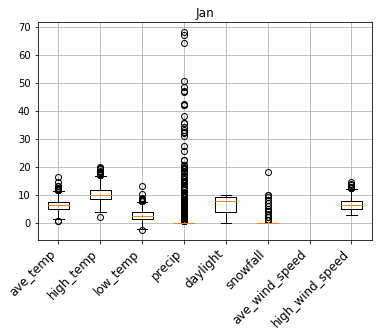

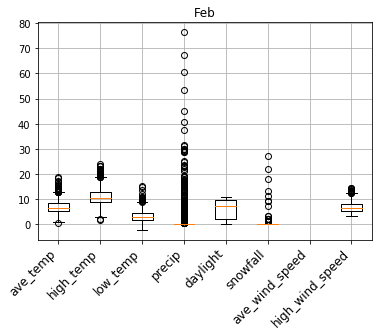

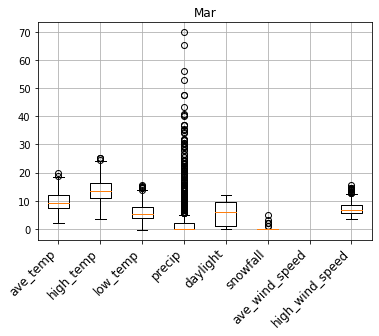

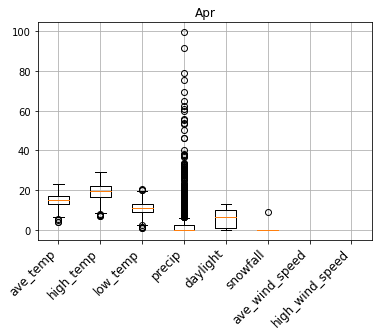

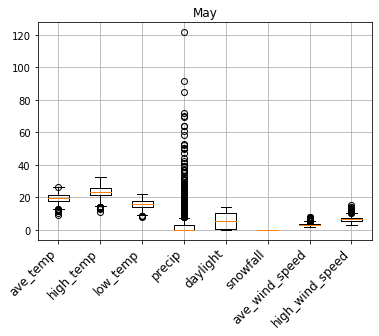

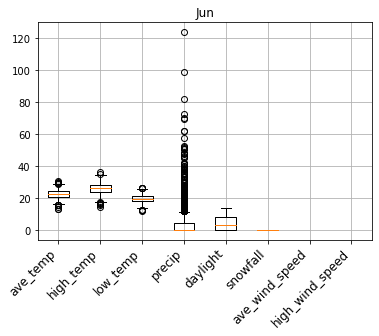

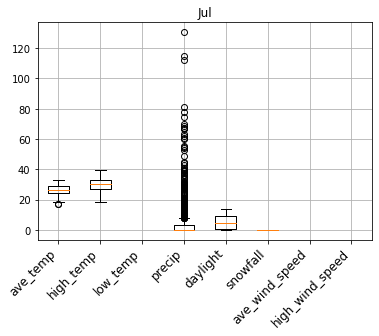

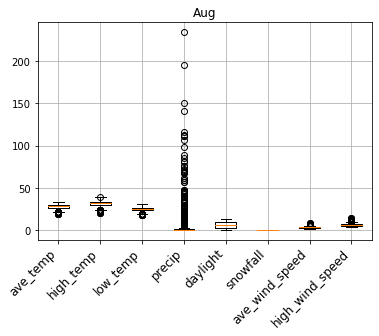

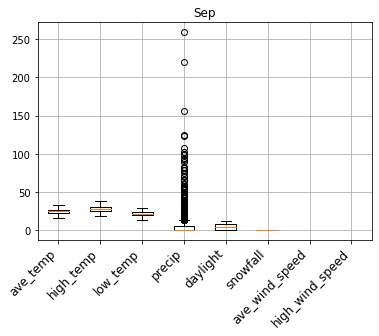

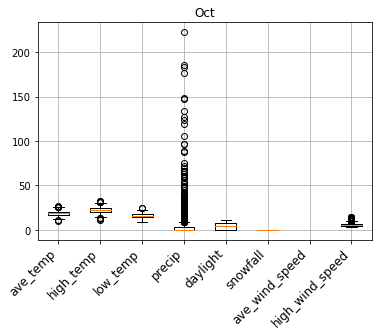

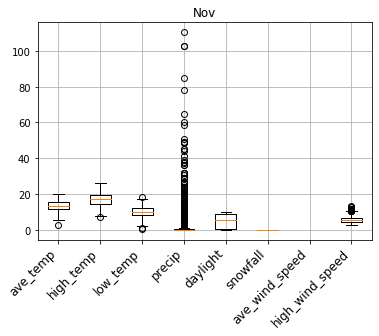

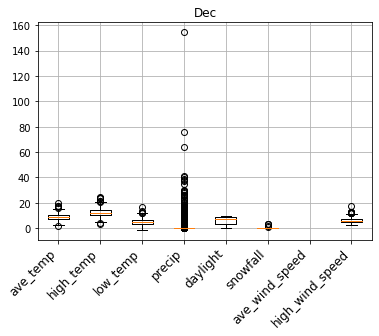

In [5]:
r = ['ave_temp', 'high_temp', 'low_temp', 'precip','daylight', 'snowfall', 'ave_wind_speed', 'high_wind_speed']
for i in range(1,13,1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(np.array(orig_monthly_weathers[i][r]))
    ax.set_xticklabels(r)
    plt.title(months[i-1])
    plt.xticks(size=12, rotation=45, ha="right")
    plt.grid()
    plt.show()

## Data refining and cleansing
In order to refine and cleanse data, I did followings:
- identified columns to use on outlier detection
- transpose nominal scale data to numerical scale
- imputed null values
- rescaled continuous variables to standard scale

In [6]:
# get dummy columns for high_wind_direc to tranpose nominal scale to numerical scale
high_wind_dummies = pd.get_dummies(weather[["high_wind_direc"]])
weather_con = pd.merge(weather, high_wind_dummies, left_index=True, right_index=True)

In [7]:
weather_con

,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987/1/1,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,...,1,0,0,0,0,0,0,0,0,0
1,1987/1/2,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,...,1,0,0,0,0,0,0,0,0,0
2,1987/1/3,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,...,0,0,0,0,0,0,0,0,0,0
3,1987/1/4,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,...,1,0,0,0,0,0,0,0,0,0
4,1987/1/5,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11318,2017/12/27,2017,12,27,4.5,9.2,1.0,0.0,9.0,0,...,1,0,0,0,0,0,0,0,0,0
11319,2017/12/28,2017,12,28,4.8,9.8,1.1,0.0,9.0,0,...,0,1,0,0,0,0,0,0,0,0
11320,2017/12/29,2017,12,29,6.1,10.5,2.3,0.0,8.6,0,...,0,1,0,0,0,0,0,0,0,0
11321,2017/12/30,2017,12,30,6.2,11.1,1.0,0.0,8.9,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# columns names after concatenating the dummy columns
weather_con.columns

Index(['yyyy/mm/dd', 'year', 'month', 'day', 'ave_temp', 'high_temp',
       'low_temp', 'precip', 'daylight', 'snowfall', 'ave_wind_speed',
       'high_wind_speed', 'high_wind_direc', 'high_wind_direc_E',
       'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
       'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
       'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
       'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
       'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW'],
      dtype='object')

In [9]:
# statistics
weather_con.describe()

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
count,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11322.000000,11323.000000,11323.000000,11323.000000,11302.000000,...,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000
mean,2002.000000,6.522830,15.729930,16.514139,20.301387,13.165165,4.335512,5.263296,0.024552,3.221908,...,0.219641,0.086373,0.152963,0.042568,0.054579,0.040537,0.081515,0.001855,0.011039,0.003091
std,8.944825,3.448883,8.800604,7.806724,7.941592,8.055336,13.293315,4.038257,0.523530,1.056939,...,0.414022,0.280926,0.359968,0.201890,0.227167,0.197224,0.273637,0.043027,0.104492,0.055514
min,1987.000000,1.000000,1.000000,0.300000,1.500000,-2.600000,0.000000,0.000000,0.000000,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,4.000000,8.000000,9.350000,13.200000,5.600000,0.000000,0.800000,0.000000,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,7.000000,16.000000,16.900000,20.600000,13.400000,0.000000,5.600000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,10.000000,23.000000,22.900000,26.600000,20.000000,1.500000,8.900000,0.000000,3.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,12.000000,31.000000,33.200000,39.500000,30.400000,259.500000,13.800000,27.000000,9.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# a list of columns to use afterwards
columns_to_use = ['year', 'month', 'day', 'ave_temp', 'high_temp',
                  'low_temp', 'precip', 'daylight', 'snowfall', 'ave_wind_speed',
                  'high_wind_speed', 'high_wind_direc_E',
                  'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
                  'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
                  'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
                  'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
                  'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW']
weather_refined = weather_con[columns_to_use]
weather_refined

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11318,2017,12,27,4.5,9.2,1.0,0.0,9.0,0,3.1,...,1,0,0,0,0,0,0,0,0,0
11319,2017,12,28,4.8,9.8,1.1,0.0,9.0,0,3.3,...,0,1,0,0,0,0,0,0,0,0
11320,2017,12,29,6.1,10.5,2.3,0.0,8.6,0,3.4,...,0,1,0,0,0,0,0,0,0,0
11321,2017,12,30,6.2,11.1,1.0,0.0,8.9,0,2.8,...,0,1,0,0,0,0,0,0,0,0


In [11]:
# dividing the refined weather dataset into each month
monthly_weathers = {}
for i in range(1,13,1):
    monthly_weathers[i] = weather_refined.query("month=={0}".format(i))
    monthly_weathers[i].reset_index(inplace=True, drop=True)
monthly_weathers[1]

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,2017,1,27,8.8,16.0,1.4,0.0,5.2,0,3.1,...,0,0,0,0,0,1,0,0,0,0
957,2017,1,28,8.4,13.6,4.6,0.0,9.1,0,2.1,...,0,1,0,0,0,0,0,0,0,0
958,2017,1,29,8.0,12.0,4.8,0.0,2.9,0,1.8,...,0,1,0,0,0,0,0,0,0,0
959,2017,1,30,11.2,19.5,6.7,0.0,7.9,0,3.0,...,0,1,0,0,0,0,0,0,0,0


### Data cleansing
Let's do two things:
1. impute null values with average values of each month
2. rescale the continuous values to standard scale according to monthly average and deviation

In [12]:
# imputation
imp = impute.SimpleImputer(strategy='mean', copy=True)
# standard scaler
ss = preprocessing.StandardScaler()
ss_columns = columns_to_use[3:11]

for m,w in monthly_weathers.items():
    # finding if there's null value
    has_null = [c for c in columns_to_use if len(w[w[c].isnull()]) > 0]
    if has_null != []:
        # impute null values
        w_with_nan = w[has_null]
        imp_w = imp.fit_transform(w_with_nan).T
        for i in range(len(has_null)):
            # replace columns with null to the imputed
            w[has_null[i]] = imp_w[i]
            if len(w[w[has_null[i]].isnull()]) > 0:
                print(has_null[i], len(w[w[has_null[i]].isnull()]))
    # standard scaler
    w[ss_columns] = pd.DataFrame(ss.fit_transform(w[ss_columns]), columns=ss_columns)

In [13]:
# cleansed dataset for January
monthly_weathers[1]

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,0.232739,-0.214742,0.677830,-0.267179,0.921880,-0.112515,3.766289,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,-1.588773,-1.975112,-0.772047,0.092428,-1.838478,-0.112515,1.079274,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,-0.150737,-0.288090,-0.672056,0.020506,-1.601028,-0.112515,-0.681184,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,0.280674,0.665443,0.277864,-0.267179,0.803155,-0.112515,1.542553,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,-1.684642,-1.975112,-1.072022,0.595877,-1.838478,0.947555,0.893963,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,2017,1,27,1.239364,2.169093,-0.622060,-0.267179,-0.295052,-0.112515,-0.125250,...,0,0,0,0,0,1,0,0,0,0
957,2017,1,28,1.047626,1.288908,0.977805,-0.267179,0.862517,-0.112515,-1.051806,...,0,1,0,0,0,0,0,0,0,0
958,2017,1,29,0.855888,0.702118,1.077796,-0.267179,-0.977721,-0.112515,-1.329773,...,0,1,0,0,0,0,0,0,0,0
959,2017,1,30,2.389793,3.452696,2.027716,-0.267179,0.506342,-0.112515,-0.217905,...,0,1,0,0,0,0,0,0,0,0


In [14]:
# statistics of cleansed January dataset
monthly_weathers[1].describe()

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
count,961.000000,961.0,961.000000,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,...,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,2002.000000,1.0,16.000000,3.117520e-16,-1.904694e-16,1.943901e-16,6.827698e-17,5.707078e-17,-3.884625e-17,-1.628943e-16,...,0.438085,0.190427,0.036420,0.008325,0.010406,0.014568,0.046826,0.003122,0.024974,0.007284
std,8.948929,0.0,8.948929,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,...,0.496410,0.392842,0.187431,0.090906,0.101530,0.119879,0.211376,0.055814,0.156127,0.085080
min,1987.000000,1.0,1.000000,-2.739201e+00,-3.038669e+00,-2.621891e+00,-2.671791e-01,-1.838478e+00,-1.125152e-01,-1.793052e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,1.0,8.000000,-6.780167e-01,-6.548342e-01,-6.720555e-01,-2.671791e-01,-7.699525e-01,-1.125152e-01,-7.738393e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,1.0,16.000000,-5.486782e-02,-3.136976e-02,-7.210628e-02,-2.671791e-01,4.469795e-01,-1.125152e-01,-2.179053e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,1.0,24.000000,6.162156e-01,5.920946e-01,5.778387e-01,-2.671791e-01,8.328360e-01,-1.125152e-01,6.159958e-01,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,1.0,31.000000,4.738585e+00,3.599393e+00,5.277441e+00,9.514121e+00,1.099967e+00,1.896874e+01,3.766289e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Outlier detection
Now that the datasets are ready, let's try outlier detections.

In [15]:
# a list of columns used for outlier detection, excluding year, month and day columns
columns_to_analyze = monthly_weathers[1].columns[3:]
columns_to_analyze

Index(['ave_temp', 'high_temp', 'low_temp', 'precip', 'daylight', 'snowfall',
       'ave_wind_speed', 'high_wind_speed', 'high_wind_direc_E',
       'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
       'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
       'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
       'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
       'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW'],
      dtype='object')

In [16]:
# making a dict of number of rows for each month, just for convenience
num_rows = {}
for i in range(1,13,1):
    num_rows[i] = monthly_weathers[i].shape[0]

### defining parameters for outlier detection
I set outlier fraction to 1%.

In [17]:
outliers_fraction = 0.01
rng = np.random.RandomState(123)
anomaly_list = ["ellipticEnvelope", "kernelDensity", "gaussianMixture", 
                "localOutlierFactor", "isolationForest", "oneClassSVM"]

In [18]:
def ellipticEnvelope(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = EllipticEnvelope(contamination=outliers_fraction)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs)
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [19]:
def kernelDensity(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as outliers
            On kernel density estimator, I defined rows with score 
            lower than 1.125 times the average as outliers
    """
    clf = KernelDensity(bandwidth=1, kernel="gaussian")
    clf.fit(inputs)
    score_pred = clf.score_samples(inputs)
    pred = np.where(score_pred <= np.average(score_pred)*1.125, -1, 1)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [20]:
def gaussianMixture(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as outliers
            On kernel density estimator, I defined rows with score 
            lower than 0.7 times the average as outliers
    """
    clf = GaussianMixture(n_components=5, covariance_type="full")
    clf.fit(inputs)
    score_pred = clf.score_samples(inputs)
    pred = np.where(score_pred <= np.average(score_pred)*0.7, -1, 1)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [21]:
def localOutlierFactor(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction, novelty=True)
    clf.fit(inputs)
    score_pred = clf._decision_function(inputs)
    pred = clf._predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [22]:
def isolationForest(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = IsolationForest(contamination=outliers_fraction,
                          max_samples="auto",
                          random_state=rng,
                          n_estimators=100)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs)
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [23]:
def oneClassSVM(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = svm.OneClassSVM(nu=outliers_fraction,
                          kernel="rbf",
                          gamma=0.03)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs).T
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

## Running each outlier detection on each month

In [24]:
monthly_pred = {}
for m,w in monthly_weathers.items():
    monthly_pred[m] = {}
    # elliptic envelope
    s,o = ellipticEnvelope(w[columns_to_analyze])
    monthly_pred[m]["ellipticEnvelope"] = {"score_pred":s, "outlier_rows":o}
    # kernel density estimator
    s,o = kernelDensity(w[columns_to_analyze])
    monthly_pred[m]["kernelDensity"] = {"score_pred":s, "outlier_rows":o}
    # gaussian mixture
    s,o = gaussianMixture(w[columns_to_analyze])
    monthly_pred[m]["gaussianMixture"] = {"score_pred":s, "outlier_rows":o}
    # local outlier factor
    s,o = localOutlierFactor(w[columns_to_analyze])
    monthly_pred[m]["localOutlierFactor"] = {"score_pred":s, "outlier_rows":o}
    # isolation forest
    s,o = isolationForest(w[columns_to_analyze])
    monthly_pred[m]["isolationForest"] = {"score_pred":s, "outlier_rows":o}
    # one class svm
    s,o = oneClassSVM(w[columns_to_analyze])
    monthly_pred[m]["oneClassSVM"] = {"score_pred":s, "outlier_rows":o}

### Gathering up

In [25]:
stats_columns = ["MONTH","DATASIZE","NORMALS","ANOMALIES","ANOMALY_RATE"]
outliers = {}
for m in months:
    outliers[m] = {}

ellipticEnvelope


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,951,10,1.04
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,920,10,1.08
4,May,961,951,10,1.04
5,Jun,930,920,10,1.08
6,Jul,961,951,10,1.04
7,Aug,961,951,10,1.04
8,Sep,930,920,10,1.08
9,Oct,961,951,10,1.04


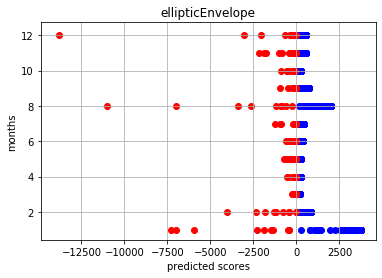

kernelDensity


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,943,18,1.87
1,Feb,876,864,12,1.37
2,Mar,961,961,0,0.0
3,Apr,930,930,0,0.0
4,May,961,960,1,0.1
5,Jun,930,925,5,0.54
6,Jul,961,952,9,0.94
7,Aug,961,942,19,1.98
8,Sep,930,920,10,1.08
9,Oct,961,950,11,1.14


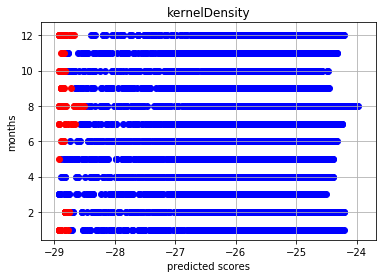

gaussianMixture


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,948,13,1.35
1,Feb,876,837,39,4.45
2,Mar,961,953,8,0.83
3,Apr,930,919,11,1.18
4,May,961,948,13,1.35
5,Jun,930,924,6,0.65
6,Jul,961,957,4,0.42
7,Aug,961,939,22,2.29
8,Sep,930,906,24,2.58
9,Oct,961,951,10,1.04


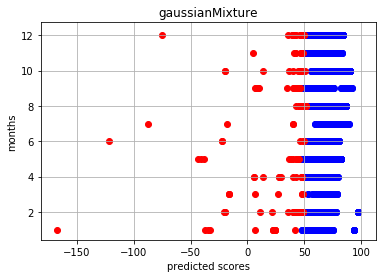

localOutlierFactor


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,953,8,0.83
1,Feb,876,869,7,0.8
2,Mar,961,952,9,0.94
3,Apr,930,922,8,0.86
4,May,961,955,6,0.62
5,Jun,930,922,8,0.86
6,Jul,961,952,9,0.94
7,Aug,961,953,8,0.83
8,Sep,930,921,9,0.97
9,Oct,961,954,7,0.73


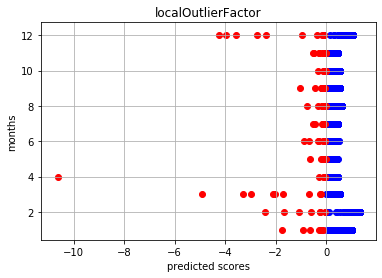

isolationForest


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,951,10,1.04
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,920,10,1.08
4,May,961,951,10,1.04
5,Jun,930,920,10,1.08
6,Jul,961,951,10,1.04
7,Aug,961,951,10,1.04
8,Sep,930,920,10,1.08
9,Oct,961,951,10,1.04


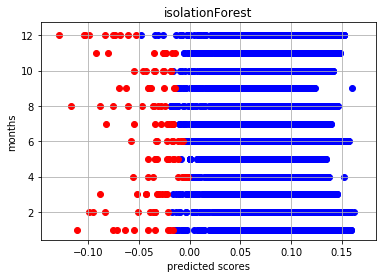

oneClassSVM


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,947,14,1.46
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,919,11,1.18
4,May,961,947,14,1.46
5,Jun,930,919,11,1.18
6,Jul,961,952,9,0.94
7,Aug,961,950,11,1.14
8,Sep,930,920,10,1.08
9,Oct,961,947,14,1.46


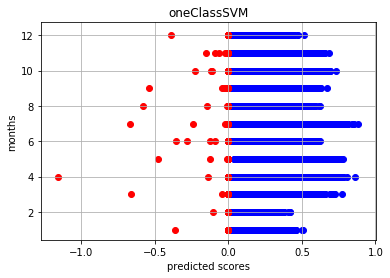

In [32]:
# drawing scatter plots on each algorithm, with month on y-axis
for aa in anomaly_list:
    data_size = []
    oks = []
    ngs = []
    ng_rate = []
    for i in range(1,13,1):
        # gathering outlier and normal rows on each month
        p_ng = monthly_pred[i][aa]["outlier_rows"]
        p_ok = np.delete(np.arange(0,num_rows[i]), p_ng)
        p_ng_score = monthly_pred[i][aa]["score_pred"][p_ng]
        p_ok_score = monthly_pred[i][aa]["score_pred"][p_ok]
        
        data_size.append(num_rows[i])
        oks.append(len(p_ok))
        ngs.append(len(p_ng))
        ng_rate.append(round(100*len(p_ng)/num_rows[i], 2))
        
        for n in p_ng:
            outliers[months[i-1]][n] = 1 if n not in outliers[months[i-1]].keys() else outliers[months[i-1]][n]+1
        
        # scatter plot 
        plt.scatter(p_ok_score, np.zeros(len(p_ok_score))+i, c="blue")
        plt.scatter(p_ng_score, np.zeros(len(p_ng_score))+i, c="red")

    print(aa)
    stats = pd.DataFrame(np.array([months,data_size,oks,ngs,ng_rate]).T, columns=stats_columns)
    display(stats)
    
    plt.title(aa)
    plt.xlabel("predicted scores")
    plt.ylabel("months")
    plt.grid(True)
    plt.show()

In [27]:
# gathered outlier rows on each month
for key in outliers.keys():
    print(str(key) + ': ' + str(outliers.get(key)))

Jan: {84: 1, 355: 5, 485: 2, 491: 2, 522: 3, 573: 1, 602: 4, 712: 2, 819: 4, 916: 4, 12: 2, 81: 3, 108: 2, 245: 2, 293: 2, 348: 3, 460: 3, 609: 3, 711: 3, 797: 3, 54: 1, 143: 1, 364: 1, 461: 1, 472: 1, 524: 1, 525: 1, 539: 1, 548: 1, 917: 1, 5: 1, 349: 1, 331: 1, 409: 1, 871: 1, 901: 1, 924: 1, 944: 1, 949: 1}
Feb: {127: 3, 141: 4, 209: 5, 218: 2, 537: 2, 695: 3, 770: 4, 776: 4, 777: 3, 85: 3, 675: 2, 832: 2, 1: 1, 2: 1, 17: 1, 39: 1, 73: 1, 86: 1, 166: 1, 201: 1, 230: 1, 270: 2, 324: 1, 325: 1, 330: 1, 477: 1, 509: 1, 510: 1, 532: 1, 533: 1, 543: 1, 565: 1, 580: 1, 582: 1, 595: 1, 601: 1, 604: 1, 650: 1, 651: 1, 655: 1, 676: 1, 707: 1, 712: 1, 734: 1, 765: 1, 797: 1, 813: 1, 838: 2, 850: 1, 852: 1, 271: 2, 635: 1, 636: 1, 658: 1, 662: 1, 673: 1, 800: 1}
Mar: {52: 3, 123: 1, 239: 1, 247: 2, 339: 2, 438: 2, 496: 3, 556: 4, 687: 1, 881: 2, 18: 1, 231: 1, 815: 1, 6: 3, 7: 2, 56: 1, 248: 2, 341: 3, 346: 1, 561: 3, 360: 1, 537: 1, 624: 1, 818: 1, 823: 1, 905: 1, 105: 1, 937: 1}
Apr: {67: 1,

In [28]:
# all the days detected as outlier
for i in range(1,13,1):
    print(months[i-1])
    display(orig_monthly_weathers[i].iloc[list(outliers[months[i-1]].keys()),:])

Jan


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
84,1989/1/23,1989,1,23,4.3,7.5,2.7,42.5,0.0,0,5.7,9.8,NNW
355,1998/1/15,1998,1,15,1.2,5.9,0.0,50.5,0.0,18,5.6,10.3,N
485,2002/1/21,2002,1,21,9.5,14.7,4.9,42.0,0.0,0,3.1,8.5,SSW
491,2002/1/27,2002,1,27,7.3,12.1,2.3,42.0,1.7,0,5.7,10.6,NW
522,2003/1/27,2003,1,27,3.8,5.6,2.4,46.5,0.0,0,2.9,4.5,NNW
573,2005/1/16,2005,1,16,5.3,8.0,2.9,47.0,0.0,0,5.7,9.5,NNW
602,2006/1/14,2006,1,14,6.6,10.7,4.1,48.5,0.0,0,3.5,13.5,N
712,2009/1/31,2009,1,31,7.8,8.9,5.7,68.0,0.2,0,4.2,7.4,NNW
819,2013/1/14,2013,1,14,3.5,10.0,0.7,64.0,0.0,8,4.1,9.0,NNW
916,2016/1/18,2016,1,18,2.8,6.2,0.2,67.0,1.4,6,3.7,7.7,NW


Feb


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
127,1991/2/15,1991,2,15,7.5,13.4,5.2,60.5,0.0,0,3.9,7.3,S
141,1992/2/1,1992,2,1,2.2,5.6,-0.5,31.0,0.4,13,6.2,12.8,N
209,1994/2/12,1994,2,12,0.9,4.1,-0.5,25.0,0.0,27,4.7,9.0,N
218,1994/2/21,1994,2,21,9.4,11.7,7.4,53.5,0.1,0,5.7,12.3,NW
537,2006/2/1,2006,2,1,5.7,8.1,4.7,45.0,0.0,0,4.6,7.4,NW
695,2011/2/18,2011,2,18,9.1,14.5,5.3,76.5,5.0,0,5.4,10.4,NW
770,2014/2/8,2014,2,8,0.3,4.0,-0.9,29.5,0.0,22,4.9,9.0,NNW
776,2014/2/14,2014,2,14,1.4,5.4,-0.2,28.5,0.0,18,3.8,6.8,NNW
777,2014/2/15,2014,2,15,3.9,6.9,-0.2,67.5,0.5,9,5.4,9.8,NNW
85,1990/2/1,1990,2,1,1.0,1.5,0.4,23.0,0.0,11,4.6,6.8,NNW


Mar


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
52,1988/3/22,1988,3,22,8.3,12.6,4.6,70.0,0.0,0,5.6,8.2,NNW
123,1990/3/31,1990,3,31,10.5,11.6,10.0,53.0,0.0,0,4.1,5.9,NNW
239,1994/3/23,1994,3,23,5.9,7.6,3.4,56.0,0.0,0,5.0,8.5,NNW
247,1994/3/31,1994,3,31,13.1,18.7,7.9,0.0,10.8,0,3.1,5.3,WSW
339,1997/3/30,1997,3,30,16.0,25.1,10.4,40.0,9.9,0,3.5,8.2,NNW
438,2001/3/5,2001,3,5,8.3,13.7,3.3,0.0,10.6,0,4.1,8.8,WSW
496,2003/3/1,2003,3,1,4.9,8.7,3.2,65.5,0.0,0,2.5,4.8,NNW
556,2004/3/30,2004,3,30,16.5,18.5,15.0,47.5,0.0,0,5.0,7.9,SW
687,2009/3/6,2009,3,6,8.1,12.6,5.6,47.5,0.0,0,3.5,7.7,NW
881,2015/3/14,2015,3,14,8.9,13.5,4.7,0.0,6.0,0,2.6,4.6,WSW


Apr


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
67,1989/4/8,1989,4,8,13.6,16.0,10.9,62.5,0.0,0,2.7,4.7,NNW
370,1999/4/11,1999,4,11,15.0,16.6,12.0,56.0,0.0,0,5.2,7.8,NNE
383,1999/4/24,1999,4,24,14.7,16.1,13.2,69.5,0.0,0,5.9,9.3,NNE
637,2008/4/8,2008,4,8,12.1,14.0,10.8,75.5,0.0,0,4.8,8.7,NNE
647,2008/4/18,2008,4,18,13.4,14.9,12.3,91.5,0.0,0,3.8,10.5,ENE
684,2009/4/25,2009,4,25,11.2,13.3,10.0,61.0,0.0,0,2.9,6.2,NW
717,2010/4/28,2010,4,28,14.1,15.4,12.5,79.0,0.0,0,2.8,5.6,NW
782,2013/4/3,2013,4,3,13.7,16.6,11.3,60.0,0.3,0,5.1,9.4,NW
785,2013/4/6,2013,4,6,17.4,20.7,15.3,99.5,0.4,0,3.7,8.8,S
812,2014/4/3,2014,4,3,13.8,15.6,12.9,65.0,0.0,0,2.0,3.4,WNW


May


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
106,1990/5/14,1990,5,14,20.0,23.6,17.5,70.0,0.0,0,2.8,8.3,NNW
205,1993/5/20,1993,5,20,20.7,26.2,17.0,0.5,5.2,0,2.8,7.0,W
262,1995/5/15,1995,5,15,17.9,18.8,16.6,63.5,0.0,0,2.1,5.2,NNE
333,1997/5/24,1997,5,24,16.4,18.1,14.6,85.0,0.0,0,2.6,7.3,ESE
526,2003/5/31,2003,5,31,21.4,23.6,18.9,72.0,0.0,0,3.1,7.0,SSW
608,2006/5/20,2006,5,20,23.7,28.1,20.0,5.5,8.4,0,5.9,8.9,W
670,2008/5/20,2008,5,20,20.4,24.1,17.7,91.5,0.0,0,3.8,10.4,SSE
772,2011/5/29,2011,5,29,18.0,19.1,16.2,69.5,0.0,0,2.3,5.4,NE
777,2012/5/3,2012,5,3,17.9,19.2,16.7,121.5,0.0,0,2.7,5.4,NW
780,2012/5/6,2012,5,6,19.7,26.2,16.0,1.0,7.6,0,3.6,10.1,W


Jun


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
32,1988/6/3,1988,6,3,22.6,24.9,18.7,33.0,0.0,0,5.9,10.4,SSW
59,1988/6/30,1988,6,30,20.6,22.3,18.1,57.5,0.0,0,NaN,NaN,NaN
149,1991/6/30,1991,6,30,26.5,30.1,22.9,4.0,3.8,0,2.7,5.7,WSW
236,1994/6/27,1994,6,27,27.2,31.7,21.3,0.0,10.7,0,NaN,NaN,NaN
319,1997/6/20,1997,6,20,23.7,25.4,21.3,81.5,0.0,0,5.2,11.6,S
683,2009/6/24,2009,6,24,24.1,26.9,22.1,31.5,2.0,0,1.9,5.5,SSW
758,2012/6/9,2012,6,9,19.0,21.8,18.0,29.5,0.0,0,3.5,5.8,SSW
768,2012/6/19,2012,6,19,23.9,27.2,22.6,72.5,0.0,0,4.2,16.3,S
815,2014/6/6,2014,6,6,19.9,20.9,19.0,123.5,0.0,0,3.5,5.5,NE
882,2016/6/13,2016,6,13,19.8,22.7,18.3,98.5,0.0,0,3.6,6.2,NNE


Jul


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
210,1993/7/25,1993,7,25,23.2,25.3,20.1,77.5,0.0,0,2.9,5.5,S
287,1996/7/9,1996,7,9,18.9,20.1,17.6,81.0,0.0,0,2.7,4.4,NE
288,1996/7/10,1996,7,10,20.6,22.4,18.5,68.5,0.0,0,5.7,8.8,NNW
384,1999/7/13,1999,7,13,23.3,24.8,21.9,130.5,0.0,0,2.5,4.4,N
385,1999/7/14,1999,7,14,26.3,30.2,23.8,66.5,1.0,0,3.0,4.7,S
406,2000/7/4,2000,7,4,26.3,31.7,19.9,112.0,4.5,0,2.4,6.4,NNE
409,2000/7/7,2000,7,7,23.4,25.4,21.2,70.0,0.0,0,4.5,7.9,N
410,2000/7/8,2000,7,8,25.6,31.5,20.9,115.0,4.9,0,6.4,12.6,N
583,2005/7/26,2005,7,26,25.4,28.2,23.3,74.5,0.0,0,5.4,9.3,NW
634,2007/7/15,2007,7,15,23.8,26.5,20.9,67.5,0.0,0,NaN,10.1,N


Aug


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
41,1988/8/11,1988,8,11,25.4,29.6,23.5,141.0,1.6,0,4.3,9.2,SSW
62,1989/8/1,1989,8,1,24.3,25.1,23.2,195.0,0.0,0,2.3,4.9,ESE
102,1990/8/10,1990,8,10,26.5,28.0,24.9,116.5,0.0,0,6.9,13.8,S
212,1993/8/27,1993,8,27,24.4,26.0,22.2,234.5,0.0,0,7.5,13.6,NNW
332,1997/8/23,1997,8,23,28.2,34.1,23.4,98.5,3.5,0,2.6,6.3,ESE
385,1999/8/14,1999,8,14,26.3,27.5,25.1,112.0,0.0,0,4.4,7.5,NE
510,2003/8/15,2003,8,15,19.5,20.7,18.4,151.0,0.0,0,3.5,5.4,NNE
655,2008/8/5,2008,8,5,27.6,30.6,25.5,111.5,0.0,0,2.4,7.8,WNW
691,2009/8/10,2009,8,10,27.1,28.6,25.0,111.5,0.3,0,3.1,6.5,S
920,2016/8/22,2016,8,22,25.7,28.3,23.2,106.5,0.0,0,4.6,11.3,W


Sep


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
102,1990/9/13,1990,9,13,26.1,30.7,22.4,35.0,1.5,0,3.7,7.6,NNE
138,1991/9/19,1991,9,19,22.4,25.5,20.5,220.5,0.0,0,4.2,9.3,S
283,1996/9/14,1996,9,14,18.1,20.0,15.7,37.5,0.0,0,5.7,7.6,NNE
291,1996/9/22,1996,9,22,19.3,23.2,17.7,259.5,0.0,0,8.4,17.0,NNW
345,1998/9/16,1998,9,16,27.3,32.8,22.3,94.0,7.1,0,6.7,11.7,W
482,2003/9/3,2003,9,3,28.7,33.4,24.1,29.0,5.8,0,2.1,10.8,NNE
563,2005/9/24,2005,9,24,22.5,25.3,20.4,34.0,0.0,0,5.5,8.2,NNE
716,2010/9/27,2010,9,27,16.3,17.8,15.6,54.0,0.0,0,3.4,5.4,NNE
819,2014/9/10,2014,9,10,23.4,26.9,19.8,81.0,1.7,0,2.3,8.7,NNE
847,2015/9/8,2015,9,8,20.0,21.0,18.8,65.5,0.0,0,2.2,4.5,NNE


Oct


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
163,1992/10/9,1992,10,9,18.7,23.4,14.8,119.0,3.8,0,4.6,11.2,NNW
443,2001/10/10,2001,10,10,17.0,19.9,14.5,186.0,0.0,0,5.0,8.3,NE
535,2004/10/9,2004,10,9,17.2,19.1,15.4,222.5,0.0,0,5.7,14.8,NNW
546,2004/10/20,2004,10,20,17.2,24.4,15.8,183.5,0.0,0,5.0,11.3,SW
594,2006/10/6,2006,10,6,17.0,18.5,16.0,133.5,0.0,0,8.6,13.5,NNW
689,2009/10/8,2009,10,8,21.2,26.3,15.8,127.0,6.3,0,6.6,13.1,S
821,2013/10/16,2013,10,16,20.1,26.0,16.2,176.5,2.8,0,6.9,14.1,NNW
841,2014/10/5,2014,10,5,17.2,22.4,15.2,148.5,0.0,0,3.1,4.7,NE
842,2014/10/6,2014,10,6,21.3,28.4,16.1,123.5,4.6,0,3.9,11.5,NW
951,2017/10/22,2017,10,22,17.4,18.1,16.8,147.5,0.0,0,3.2,7.1,NE


Nov


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
119,1990/11/30,1990,11,30,16.2,21.2,11.5,102.5,0.0,0,6.0,11.3,SSW
147,1991/11/28,1991,11,28,11.3,19.1,8.8,65.0,0.0,0,2.2,7.6,SSW
169,1992/11/20,1992,11,20,14.6,20.0,11.5,102.5,0.0,0,3.2,8.7,NNW
192,1993/11/13,1993,11,13,15.9,20.1,14.4,110.5,0.0,0,3.3,7.4,ESE
360,1999/11/1,1999,11,1,19.1,23.8,15.0,48.5,0.1,0,3.5,10.9,SW
504,2003/11/25,2003,11,25,11.5,14.8,9.3,58.5,0.0,0,4.2,6.3,NNW
670,2009/11/11,2009,11,11,17.3,18.8,15.7,85.0,0.0,0,2.5,5.4,NW
690,2010/11/1,2010,11,1,16.6,19.6,14.2,50.5,2.3,0,2.8,7.0,NW
738,2011/11/19,2011,11,19,16.3,22.0,12.1,78.0,0.0,0,3.2,9.7,S
766,2012/11/17,2012,11,17,13.7,17.2,10.1,60.5,0.0,0,3.6,6.9,NW


Dec


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
12,1987/12/13,1987,12,13,3.0,7.9,1.0,29.5,0.0,3,4.7,6.9,NE
162,1992/12/8,1992,12,8,17.2,20.6,13.6,38.0,3.0,0,4.3,9.9,S
531,2004/12/5,2004,12,5,17.5,24.8,8.5,41.0,6.5,0,5.9,17.5,SW
614,2006/12/26,2006,12,26,8.1,10.9,5.7,154.5,0.0,0,4.9,8.1,NNW
692,2009/12/11,2009,12,11,8.1,9.3,7.4,38.5,0.0,0,3.8,7.0,NNW
715,2010/12/3,2010,12,3,17.0,23.7,12.3,76.0,5.3,0,4.5,10.6,S
746,2011/12/3,2011,12,3,11.1,18.9,6.7,35.0,0.5,0,3.4,5.9,NNW
804,2012/12/30,2012,12,30,7.2,8.7,6.0,40.0,0.0,0,2.1,4.7,NW
878,2015/12/11,2015,12,11,14.7,24.1,6.9,64.0,4.9,0,4.6,11.0,SSW
912,2016/12/14,2016,12,14,8.1,11.3,5.3,37.0,0.3,0,3.2,6.4,NNW


In [29]:
# pick up days detected by more than or equal to 3 algorithms
out_more_than_three = {}
for m,v in outliers.items():
    out_more_than_three[m] = []
    for k,n in v.items():
        if n >= 3:
            out_more_than_three[m].append(k)

In [30]:
for key in out_more_than_three.keys():
    print(str(key) + ': ' + str(out_more_than_three.get(key)))

Jan: [355, 522, 602, 819, 916, 81, 348, 460, 609, 711, 797]
Feb: [127, 141, 209, 695, 770, 776, 777, 85]
Mar: [52, 496, 556, 6, 341, 561]
Apr: [647, 785, 812, 752, 37, 484]
May: [333, 670, 777, 317]
Jun: [319, 768, 815, 882, 769]
Jul: [287, 288, 384, 406, 410, 583, 155]
Aug: [41, 62, 102, 212, 332, 510, 920, 191, 541, 582, 712]
Sep: [138, 291, 345, 482, 79, 256, 430, 740, 391]
Oct: [443, 535, 546, 594, 689, 821, 841, 842, 951, 612]
Nov: [119, 169, 192, 360, 670, 738, 893, 894]
Dec: [12, 162, 531, 614, 715, 878, 5, 93, 150, 473, 557]


In [31]:
# days detected by more than or equal to 3 algorithms
for i in range(1,13,1):
    print(months[i-1])
    display(orig_monthly_weathers[i].iloc[out_more_than_three[months[i-1]],:])

Jan


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
355,1998/1/15,1998,1,15,1.2,5.9,0.0,50.5,0.0,18,5.6,10.3,N
522,2003/1/27,2003,1,27,3.8,5.6,2.4,46.5,0.0,0,2.9,4.5,NNW
602,2006/1/14,2006,1,14,6.6,10.7,4.1,48.5,0.0,0,3.5,13.5,N
819,2013/1/14,2013,1,14,3.5,10.0,0.7,64.0,0.0,8,4.1,9.0,NNW
916,2016/1/18,2016,1,18,2.8,6.2,0.2,67.0,1.4,6,3.7,7.7,NW
81,1989/1/20,1989,1,20,14.6,19.2,10.1,38.0,0.1,0,4.4,9.7,SW
348,1998/1/8,1998,1,8,2.4,5.0,0.4,34.0,0.0,10,3.4,8.8,N
460,2001/1/27,2001,1,27,1.8,4.5,0.5,33.0,0.0,9,6.3,10.8,NNW
609,2006/1/21,2006,1,21,1.3,4.5,0.0,15.0,0.0,10,3.9,6.7,NNW
711,2009/1/30,2009,1,30,9.6,11.5,8.3,31.0,0.0,0,2.4,4.9,ENE


Feb


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
127,1991/2/15,1991,2,15,7.5,13.4,5.2,60.5,0.0,0,3.9,7.3,S
141,1992/2/1,1992,2,1,2.2,5.6,-0.5,31.0,0.4,13,6.2,12.8,N
209,1994/2/12,1994,2,12,0.9,4.1,-0.5,25.0,0.0,27,4.7,9.0,N
695,2011/2/18,2011,2,18,9.1,14.5,5.3,76.5,5.0,0,5.4,10.4,NW
770,2014/2/8,2014,2,8,0.3,4.0,-0.9,29.5,0.0,22,4.9,9.0,NNW
776,2014/2/14,2014,2,14,1.4,5.4,-0.2,28.5,0.0,18,3.8,6.8,NNW
777,2014/2/15,2014,2,15,3.9,6.9,-0.2,67.5,0.5,9,5.4,9.8,NNW
85,1990/2/1,1990,2,1,1.0,1.5,0.4,23.0,0.0,11,4.6,6.8,NNW


Mar


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
52,1988/3/22,1988,3,22,8.3,12.6,4.6,70.0,0.0,0,5.6,8.2,NNW
496,2003/3/1,2003,3,1,4.9,8.7,3.2,65.5,0.0,0,2.5,4.8,NNW
556,2004/3/30,2004,3,30,16.5,18.5,15.0,47.5,0.0,0,5.0,7.9,SW
6,1987/3/7,1987,3,7,3.3,7.0,0.7,16.5,2.2,3,5.0,9.7,N
341,1998/3/1,1998,3,1,4.4,8.2,0.7,40.5,0.0,5,5.8,10.6,N
561,2005/3/4,2005,3,4,2.1,3.6,0.7,20.5,0.5,2,5.1,8.6,NNW


Apr


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
647,2008/4/18,2008,4,18,13.4,14.9,12.3,91.5,0.0,0,3.8,10.5,ENE
785,2013/4/6,2013,4,6,17.4,20.7,15.3,99.5,0.4,0,3.7,8.8,S
812,2014/4/3,2014,4,3,13.8,15.6,12.9,65.0,0.0,0,2.0,3.4,WNW
752,2012/4/3,2012,4,3,14.0,17.7,9.7,21.5,2.0,0,6.5,15.1,SSE
37,1988/4/8,1988,4,8,3.8,6.8,0.7,31.5,0.0,9,6.0,9.3,NNW
484,2003/4/5,2003,4,5,6.9,9.1,5.6,55.5,0.0,0,5.9,9.7,N


May


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
333,1997/5/24,1997,5,24,16.4,18.1,14.6,85.0,0.0,0,2.6,7.3,ESE
670,2008/5/20,2008,5,20,20.4,24.1,17.7,91.5,0.0,0,3.8,10.4,SSE
777,2012/5/3,2012,5,3,17.9,19.2,16.7,121.5,0.0,0,2.7,5.4,NW
317,1997/5/8,1997,5,8,23.2,27.4,19.0,10.5,3.0,0,7.1,15.4,SW


Jun


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
319,1997/6/20,1997,6,20,23.7,25.4,21.3,81.5,0.0,0,5.2,11.6,S
768,2012/6/19,2012,6,19,23.9,27.2,22.6,72.5,0.0,0,4.2,16.3,S
815,2014/6/6,2014,6,6,19.9,20.9,19.0,123.5,0.0,0,3.5,5.5,NE
882,2016/6/13,2016,6,13,19.8,22.7,18.3,98.5,0.0,0,3.6,6.2,NNE
769,2012/6/20,2012,6,20,26.9,30.2,22.4,0.0,4.9,0,6.5,15.7,S


Jul


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
287,1996/7/9,1996,7,9,18.9,20.1,17.6,81.0,0.0,0,2.7,4.4,NE
288,1996/7/10,1996,7,10,20.6,22.4,18.5,68.5,0.0,0,5.7,8.8,NNW
384,1999/7/13,1999,7,13,23.3,24.8,21.9,130.5,0.0,0,2.5,4.4,N
406,2000/7/4,2000,7,4,26.3,31.7,19.9,112.0,4.5,0,2.4,6.4,NNE
410,2000/7/8,2000,7,8,25.6,31.5,20.9,115.0,4.9,0,6.4,12.6,N
583,2005/7/26,2005,7,26,25.4,28.2,23.3,74.5,0.0,0,5.4,9.3,NW
155,1992/7/1,1992,7,1,24.6,30.5,17.0,9.5,10.6,0,4.6,11.6,NNW


Aug


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
41,1988/8/11,1988,8,11,25.4,29.6,23.5,141.0,1.6,0,4.3,9.2,SSW
62,1989/8/1,1989,8,1,24.3,25.1,23.2,195.0,0.0,0,2.3,4.9,ESE
102,1990/8/10,1990,8,10,26.5,28.0,24.9,116.5,0.0,0,6.9,13.8,S
212,1993/8/27,1993,8,27,24.4,26.0,22.2,234.5,0.0,0,7.5,13.6,NNW
332,1997/8/23,1997,8,23,28.2,34.1,23.4,98.5,3.5,0,2.6,6.3,ESE
510,2003/8/15,2003,8,15,19.5,20.7,18.4,151.0,0.0,0,3.5,5.4,NNE
920,2016/8/22,2016,8,22,25.7,28.3,23.2,106.5,0.0,0,4.6,11.3,W
191,1993/8/6,1993,8,6,19.2,20.2,18.5,69.0,0.0,0,4.0,5.5,NNW
541,2004/8/15,2004,8,15,21.2,28.5,18.1,14.0,0.0,0,3.8,10.5,NNE
582,2005/8/25,2005,8,25,24.6,26.6,21.9,70.0,0.0,0,5.4,13.1,ESE


Sep


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
138,1991/9/19,1991,9,19,22.4,25.5,20.5,220.5,0.0,0,4.2,9.3,S
291,1996/9/22,1996,9,22,19.3,23.2,17.7,259.5,0.0,0,8.4,17.0,NNW
345,1998/9/16,1998,9,16,27.3,32.8,22.3,94.0,7.1,0,6.7,11.7,W
482,2003/9/3,2003,9,3,28.7,33.4,24.1,29.0,5.8,0,2.1,10.8,NNE
79,1989/9/20,1989,9,20,23.8,30.5,18.6,78.5,9.6,0,5.9,11.1,NNW
256,1995/9/17,1995,9,17,17.2,19.8,15.1,93.5,0.1,0,6.8,16.0,N
430,2001/9/11,2001,9,11,26.0,27.8,24.7,99.5,0.0,0,5.5,17.7,NE
740,2011/9/21,2011,9,21,22.2,26.3,17.3,124.0,0.0,0,5.9,16.9,S
391,2000/9/2,2000,9,2,32.0,37.8,28.2,2.5,9.9,0,3.3,5.5,NW


Oct


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
443,2001/10/10,2001,10,10,17.0,19.9,14.5,186.0,0.0,0,5.0,8.3,NE
535,2004/10/9,2004,10,9,17.2,19.1,15.4,222.5,0.0,0,5.7,14.8,NNW
546,2004/10/20,2004,10,20,17.2,24.4,15.8,183.5,0.0,0,5.0,11.3,SW
594,2006/10/6,2006,10,6,17.0,18.5,16.0,133.5,0.0,0,8.6,13.5,NNW
689,2009/10/8,2009,10,8,21.2,26.3,15.8,127.0,6.3,0,6.6,13.1,S
821,2013/10/16,2013,10,16,20.1,26.0,16.2,176.5,2.8,0,6.9,14.1,NNW
841,2014/10/5,2014,10,5,17.2,22.4,15.2,148.5,0.0,0,3.1,4.7,NE
842,2014/10/6,2014,10,6,21.3,28.4,16.1,123.5,4.6,0,3.9,11.5,NW
951,2017/10/22,2017,10,22,17.4,18.1,16.8,147.5,0.0,0,3.2,7.1,NE
612,2006/10/24,2006,10,24,13.4,14.9,12.1,41.0,0.0,0,7.6,11.7,N


Nov


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
119,1990/11/30,1990,11,30,16.2,21.2,11.5,102.5,0.0,0,6.0,11.3,SSW
169,1992/11/20,1992,11,20,14.6,20.0,11.5,102.5,0.0,0,3.2,8.7,NNW
192,1993/11/13,1993,11,13,15.9,20.1,14.4,110.5,0.0,0,3.3,7.4,ESE
360,1999/11/1,1999,11,1,19.1,23.8,15.0,48.5,0.1,0,3.5,10.9,SW
670,2009/11/11,2009,11,11,17.3,18.8,15.7,85.0,0.0,0,2.5,5.4,NW
738,2011/11/19,2011,11,19,16.3,22.0,12.1,78.0,0.0,0,3.2,9.7,S
893,2016/11/24,2016,11,24,2.8,8.6,0.9,23.0,0.0,0,2.9,4.9,NW
894,2016/11/25,2016,11,25,5.6,10.8,0.3,0.0,9.3,0,1.9,3.4,SE


Dec


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
12,1987/12/13,1987,12,13,3.0,7.9,1.0,29.5,0.0,3,4.7,6.9,NE
162,1992/12/8,1992,12,8,17.2,20.6,13.6,38.0,3.0,0,4.3,9.9,S
531,2004/12/5,2004,12,5,17.5,24.8,8.5,41.0,6.5,0,5.9,17.5,SW
614,2006/12/26,2006,12,26,8.1,10.9,5.7,154.5,0.0,0,4.9,8.1,NNW
715,2010/12/3,2010,12,3,17.0,23.7,12.3,76.0,5.3,0,4.5,10.6,S
878,2015/12/11,2015,12,11,14.7,24.1,6.9,64.0,4.9,0,4.6,11.0,SSW
5,1987/12/6,1987,12,6,2.9,5.2,0.9,17.5,0.0,2,3.7,6.2,NNE
93,1990/12/1,1990,12,1,19.7,23.5,17.0,0.0,9.3,0,4.6,10.1,SSW
150,1991/12/27,1991,12,27,2.8,4.9,1.2,15.5,0.0,1,3.1,5.9,NNW
473,2002/12/9,2002,12,9,1.7,3.0,0.8,25.0,0.0,3,3.7,5.9,NNW
